**Importing Required Libraries**

In [1]:
import os
import tensorflow as tf
tf.executing_eagerly()
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


**Accessing Data From Drive**

In [4]:
from google.colab import drive     
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir("/content/drive/My Drive/Neural Style Transfer")

In [9]:
os.listdir()

['content.jpg',
 'style.jpg',
 'style2.jpg',
 'Style1.jpg',
 'style3.jpg',
 'stylized-image.png',
 'Neural_Style_Transfer.ipynb',
 'axel.jpg']

**Defining VGG19 Model**

In [7]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

**Helper Functions**

In [10]:
def load_and_process_image(path):
    img = load_img(path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [11]:
def deprocess(w):
    ''' perform the inverse of the preprocessiing step 
    '''
    w[:, :, 0] += 103.939
    w[:, :, 1] += 116.779
    w[:, :, 2] += 123.68
    w = w[:, :, ::-1]

    w = np.clip(w, 0, 255).astype('uint8')
    return w

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

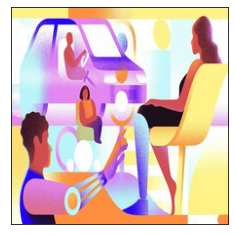

In [36]:
img = load_and_process_image('Style1.jpg')
display_image(img)

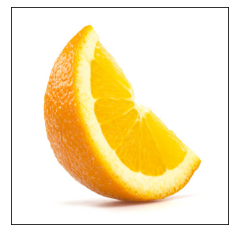

In [37]:
img = load_and_process_image('o.jpg')
display_image(img)

In [38]:
#content and style models
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

content_layer = 'block5_conv2'

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input, outputs = model.get_layer(layer).output) for layer in style_layers]

In [39]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [40]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

In [41]:
#Style cost
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    
    return J_style

In [42]:
#Training
import time

generated_images = []

def training_loop(content_path, style_path, iterations = 200, a = 15., b = 25.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype = tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate = 7.)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [43]:
final = training_loop('o.jpg','Style1.jpg')

Cost at 0: 59429670912.0. Time elapsed: 2.28483247756958
Cost at 20: 4949201920.0. Time elapsed: 11.521374225616455
Cost at 40: 1673335296.0. Time elapsed: 20.88405442237854
Cost at 60: 860638784.0. Time elapsed: 30.315151691436768
Cost at 80: 567248896.0. Time elapsed: 39.67126178741455
Cost at 100: 425982304.0. Time elapsed: 48.948521852493286
Cost at 120: 342983392.0. Time elapsed: 58.150408029556274
Cost at 140: 288443040.0. Time elapsed: 67.31243681907654
Cost at 160: 250049040.0. Time elapsed: 76.47982501983643
Cost at 180: 221374000.0. Time elapsed: 85.67230248451233


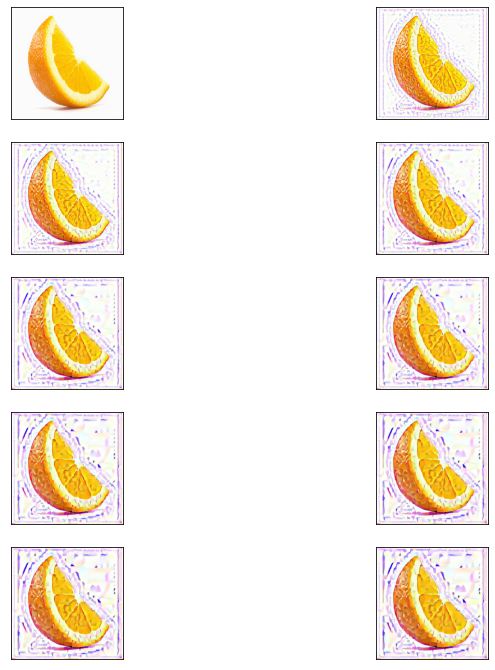

In [44]:
#plot the result
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

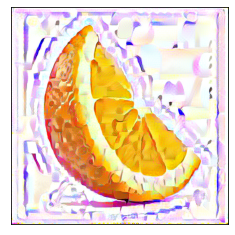

In [45]:
display_image(final)